In [1]:
print("Hello")

Hello


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importing necessary libraries and modules

import os  # Module for interacting with the operating system (e.g., file operations)
import time  # Module for accessing time-related functions
import random  # Module for generating random numbers
import numpy as np  # NumPy library for numerical computations with arrays and matrices
import pandas as pd  # Pandas library for data manipulation and analysis
import cv2  # OpenCV library for computer vision tasks such as image processing
import torch  # PyTorch library for deep learning tasks
from tqdm.auto import tqdm  # tqdm library for displaying progress bars during iterations
import shutil as sh  # shutil module for high-level file operations (e.g., copying, moving files)

from IPython.display import Image, clear_output  # IPython.display for displaying images and clearing output in Jupyter notebooks
import matplotlib.pyplot as plt  # Matplotlib library for creating visualizations

# %matplotlib inline: IPython magic command to display Matplotlib plots inline in Jupyter notebooks
%matplotlib inline


In [6]:
# Cloning YOLOv5 repository from GitHub
!git clone https://github.com/ultralytics/yolov5  # clone repo

# Installing/updating pycocotools library
!pip install -U pycocotools

# Installing dependencies listed in the requirements.txt file of YOLOv5 repository
!pip install -qr yolov5/requirements.txt  # install dependencies

# Copying the requirements.txt file from yolov5 directory to current directory
!cp yolov5/requirements.txt ./  # copy requirements.txt file


In [7]:
# Image dimensions
img_h, img_w, num_channels = (380, 676, 3)

# Read bounding box data from CSV file
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Data_Files/object detection data set/train_solution_bounding_boxes (1).csv')

# Rename the 'image' column to 'image_id' to match the convention in YOLOv5
df.rename(columns={'image':'image_id'}, inplace=True)

# Remove the file extension from the image id column
df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])

# Calculate the center coordinates of bounding boxes
df['x_center'] = (df['xmin'] + df['xmax']) / 2
df['y_center'] = (df['ymin'] + df['ymax']) / 2

# Calculate width and height of bounding boxes
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']

# Set all bounding boxes to the same class (assuming there's only one class)
df['classes'] = 0

# Normalize bounding box coordinates and dimensions to range [0, 1]
df['x_center'] = df['x_center'] / img_w
df['w'] = df['w'] / img_w
df['y_center'] = df['y_center'] / img_h
df['h'] = df['h'] / img_h

# Display the first few rows of the DataFrame
df.head()


,image_id,xmin,ymin,xmax,ymax,x_center,y_center,w,h,classes
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,0.450434,0.539817,0.068741,0.095238,0
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,0.100217,0.557191,0.155572,0.129987,0
2,vid_4_10040,239.192475,176.764801,361.968162,236.430180,0.444645,0.543678,0.181621,0.157014,0
3,vid_4_10020,496.483358,172.363256,630.020260,231.539575,0.833213,0.531451,0.197540,0.155727,0
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,0.110347,0.559122,0.171491,0.136422,0


In [8]:
# Get a list of unique image IDs
index = list(set(df.image_id))

# Select a random image ID
image = random.choice(index)
print("Image ID: %s" % (image))

# Read the image using OpenCV
img = cv2.imread(f'/content/drive/MyDrive/Colab_Notebooks/Data_Files/object detection data set/training_images/{image}.jpg')

# Display the shape of the image (height, width, number of channels)
img.shape


Image ID: vid_4_1800


(380, 676, 3)

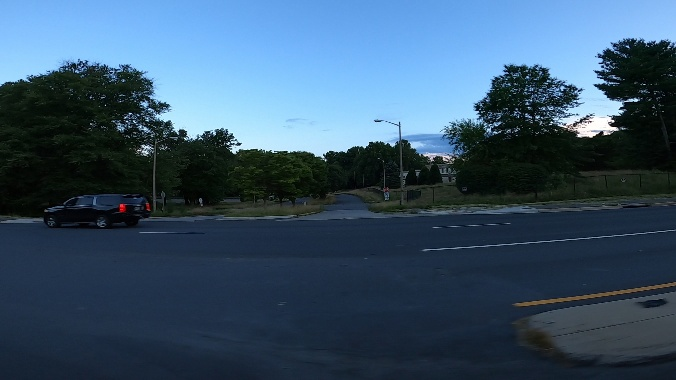

In [9]:
# Select a random image ID from the list of unique image IDs
image = random.choice(index)

# Display the selected image using IPython.display.Image
Image(filename=f'/content/drive/MyDrive/Colab_Notebooks/Data_Files/object detection data set/training_images/{image}.jpg', width=600)


In [10]:
# Define the source directory containing the images
source = 'training_images'

# Loop through each fold (in this case, only one fold [0])
if True:
    for fold in [0]:
        # Split the index list into validation and training indices
        val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]

        # Iterate over each image in the DataFrame
        for name, mini in tqdm(df.groupby('image_id')):
            # Determine whether the image belongs to the validation or training set
            if name in val_index:
                path2save = 'val2017/'
            else:
                path2save = 'train2017/'

            # Create directories to save labels and images if they don't exist
            if not os.path.exists('/tmp/convertor/fold{}/labels/'.format(fold) + path2save):
                os.makedirs('/tmp/convertor/fold{}/labels/'.format(fold) + path2save)

            # Write bounding box annotations to label files
            with open('/tmp/convertor/fold{}/labels/'.format(fold) + path2save + name + ".txt", 'w+') as f:
                row = mini[['classes', 'x_center', 'y_center', 'w', 'h']].astype(float).values
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")

            # Create directories to save images if they don't exist
            if not os.path.exists('/tmp/convertor/fold{}/images/{}'.format(fold, path2save)):
                os.makedirs('/tmp/convertor/fold{}/images/{}'.format(fold, path2save))

            # Copy images to the appropriate directory
            sh.copy("/content/drive/MyDrive/Colab_Notebooks/Data_Files/object detection data set/{}/{}.jpg".format(source, name), '/tmp/convertor/fold{}/images/{}/{}.jpg'.format(fold, path2save, name))


  0%|          | 0/355 [00:00<?, ?it/s]

In [ ]:
!python yolov5/detect.py --weights yolov5/yolov5s.pt --img 676 --conf 0.4 --source /content/drive/MyDrive/Colab_Notebooks/Data_Files/car_detection_data_set/testing_images
# this part of the code determines the directories for the yolofile the weights to be loaded,
# setting the input imgae sizes, and confidence score setup

In [13]:
# Initialize an empty list to store the predicted file names
predicted_files = []

# Traverse the directory structure under "runs/detect/py"
for (dirpath, dirnames, filenames) in os.walk("runs/detect/py"):
    # Extend the predicted_files list with the filenames found in the current directory
    predicted_files.extend(filenames)


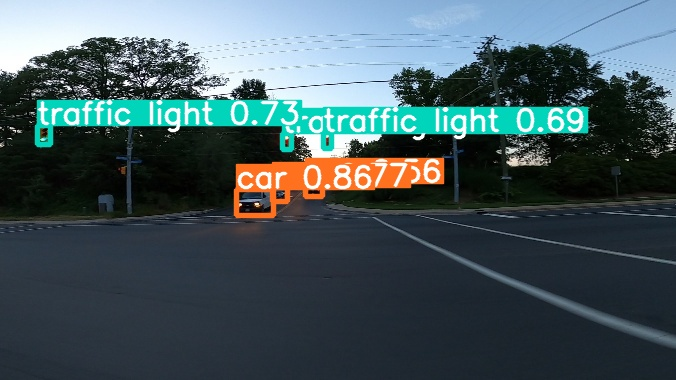

In [23]:
# Display the image located at the specified path
Image(filename='yolov5/runs/detect/exp/vid_5_30860.jpg')

In [25]:
# custom image to test
!python yolov5/detect.py --weights yolov5/yolov5s.pt --img 676 --conf 0.4 --source /content/testing_car_image.jpg

detect: weights=['yolov5/yolov5s.pt'], source=/content/testing_car_image.jpg, data=yolov5/data/coco128.yaml, imgsz=[676, 676], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-295-gac6c4383 Python-3.10.12 torch-2.2.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
WARNING ⚠️ --img-size [676, 676] must be multiple of max stride 32, updating to [704, 704]
image 1/1 /content/testing_car_image.jpg: 480x704 6 cars, 2 traffic lights, 431.4ms
Speed: 9.7ms pre-process, 431.4ms inference, 3.9ms NMS per image at shape (1, 3, 704, 704)
Results saved to yolov5/runs/detect/exp3


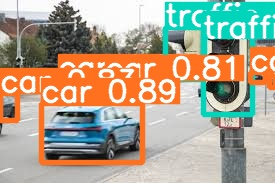

In [27]:
# Display the Custom image saved at the specified path
Image(filename='yolov5/runs/detect/exp3/testing_car_image.jpg')

In [ ]:
# custom image to test
!python yolov5/detect.py --weights yolov5/yolov5s.pt --img 676 --conf 0.4 --source /content/testing_car_image2.jpg

In [ ]:
# Display the Custom image saved at the specified path
Image(filename='yolov5/runs/detect/exp4/testing_car_image2.jpg')

In [ ]:
# custom video to test
!python yolov5/detect.py --weights yolov5/yolov5s.pt --img 676 --conf 0.4 --source /content/Car_test_video.mp4

In [ ]:
from IPython.display import Video

# Display the custom video saved at the specified path with customized width and height
Video('/content/yolov5/runs/detect/exp4/Car_test_video.mp4', width=800, height=600)


If a video plays it's good
else download the video from saved location and run in media player

In [39]:
# animated car image to test
!python yolov5/detect.py --weights yolov5/yolov5s.pt --img 676 --conf 0.4 --source /content/cartoon_car.jpg

detect: weights=['yolov5/yolov5s.pt'], source=/content/cartoon_car.jpg, data=yolov5/data/coco128.yaml, imgsz=[676, 676], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-295-gac6c4383 Python-3.10.12 torch-2.2.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
WARNING ⚠️ --img-size [676, 676] must be multiple of max stride 32, updating to [704, 704]
image 1/1 /content/cartoon_car.jpg: 416x704 1 truck, 379.9ms
Speed: 5.2ms pre-process, 379.9ms inference, 3.7ms NMS per image at shape (1, 3, 704, 704)
Results saved to yolov5/runs/detect/exp5


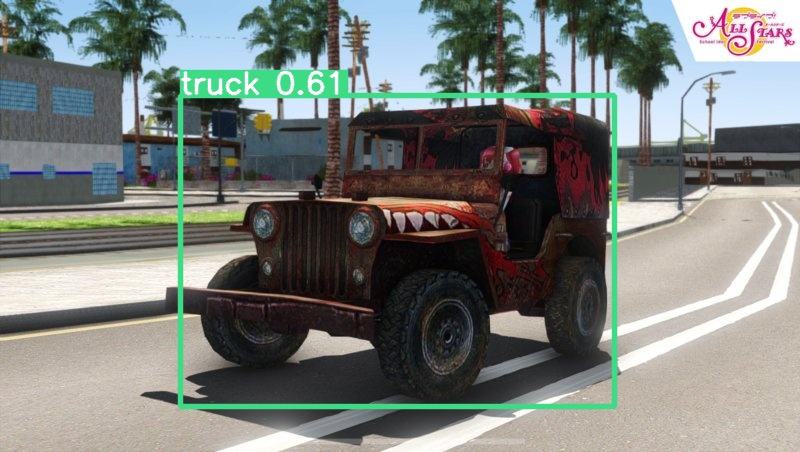

In [40]:
# Display animated car image saved at the specified path
Image(filename='yolov5/runs/detect/exp5/cartoon_car.jpg')

In [41]:
# bike image to test
!python yolov5/detect.py --weights yolov5/yolov5s.pt --img 676 --conf 0.4 --source /content/bike_test.jpg

detect: weights=['yolov5/yolov5s.pt'], source=/content/bike_test.jpg, data=yolov5/data/coco128.yaml, imgsz=[676, 676], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-295-gac6c4383 Python-3.10.12 torch-2.2.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
WARNING ⚠️ --img-size [676, 676] must be multiple of max stride 32, updating to [704, 704]
image 1/1 /content/bike_test.jpg: 416x704 1 person, 1 motorcycle, 298.8ms
Speed: 2.2ms pre-process, 298.8ms inference, 3.1ms NMS per image at shape (1, 3, 704, 704)
Results saved to yolov5/runs/detect/exp6


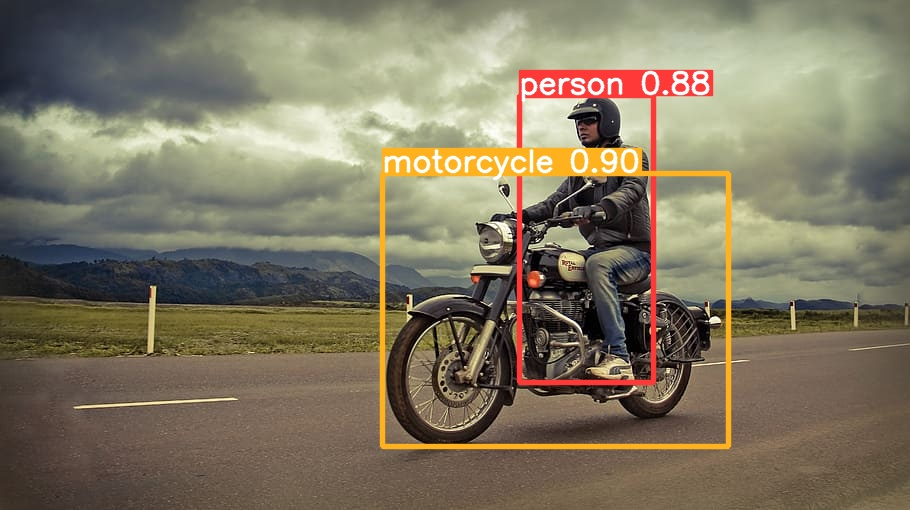

In [42]:
# Display the  imagebike saved at the specified path
Image(filename='yolov5/runs/detect/exp6/bike_test.jpg')

In [43]:
# toy car image to test
!python yolov5/detect.py --weights yolov5/yolov5s.pt --img 676 --conf 0.4 --source /content/toy.jpg

detect: weights=['yolov5/yolov5s.pt'], source=/content/toy.jpg, data=yolov5/data/coco128.yaml, imgsz=[676, 676], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-295-gac6c4383 Python-3.10.12 torch-2.2.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
WARNING ⚠️ --img-size [676, 676] must be multiple of max stride 32, updating to [704, 704]
image 1/1 /content/toy.jpg: 544x704 1 truck, 421.6ms
Speed: 3.4ms pre-process, 421.6ms inference, 1.8ms NMS per image at shape (1, 3, 704, 704)
Results saved to yolov5/runs/detect/exp7


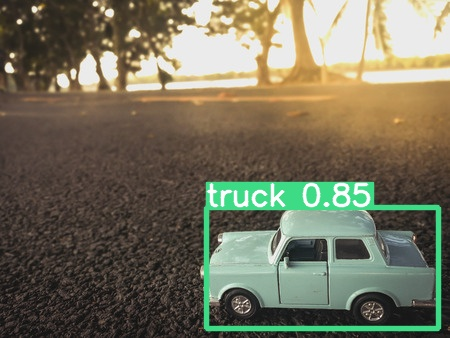

In [44]:
# Display the toy car image saved at the specified path
Image(filename='yolov5/runs/detect/exp7/toy.jpg')